<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Constants" data-toc-modified-id="Imports-+-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li><li><span><a href="#Standardize-histograms" data-toc-modified-id="Standardize-histograms-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Standardize histograms</a></span></li></ul></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Dumb-Baseline-Models" data-toc-modified-id="Dumb-Baseline-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dumb Baseline Models</a></span><ul class="toc-item"><li><span><a href="#Incountry:-predict-country-mean" data-toc-modified-id="Incountry:-predict-country-mean-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Incountry: predict country mean</a></span></li><li><span><a href="#Linear-NL" data-toc-modified-id="Linear-NL-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear NL</a></span></li></ul></li><li><span><a href="#OOC-Predictions" data-toc-modified-id="OOC-Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>OOC Predictions</a></span><ul class="toc-item"><li><span><a href="#rgb" data-toc-modified-id="rgb-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>rgb</a></span></li><li><span><a href="#ms" data-toc-modified-id="ms-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ms</a></span></li><li><span><a href="#nl" data-toc-modified-id="nl-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>nl</a></span></li><li><span><a href="#msnl" data-toc-modified-id="msnl-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>msnl</a></span></li></ul></li><li><span><a href="#Incountry-Predictions" data-toc-modified-id="Incountry-Predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Incountry Predictions</a></span><ul class="toc-item"><li><span><a href="#Predict-country-mean" data-toc-modified-id="Predict-country-mean-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Predict country mean</a></span></li><li><span><a href="#Histogram-model" data-toc-modified-id="Histogram-model-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Histogram model</a></span></li></ul></li></ul></div>

# Imports + Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

sys.path.append('../')
from batchers import batcher, dataset_constants
from histograms import get_per_image_histograms, split_nl_hist
from models.linear_model import train_linear_logo
from utils.analysis import calc_score, evaluate
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds

In [3]:
SPLITS = ['train', 'val', 'test']
FOLDS = ['A', 'B', 'C', 'D', 'E']

DATASET_NAME = 'LSMS'
LABEL_NAME = 'wealthpooled'

# Load histograms (or create if needed)

In [4]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [5]:
def get_batcher(tfrecord_files):
    return batcher.Batcher(
        tfrecord_files=tfrecord_files,
        dataset=DATASET_NAME,
        batch_size=128,
        ls_bands='ms',
        nl_band='merge',
        label_name=LABEL_NAME,
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)

In [6]:
file_path = '../data/lsms_image_hists.npz'

if not os.path.exists(file_path):
    tfrecord_paths = batcher.get_lsms_tfrecord_paths(dataset_constants.SURVEY_NAMES['LSMS'])
    init_iter, batch_op = get_batcher(tfrecord_paths).get_batch()
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)

In [7]:
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

image_hists: dtype=int64, shape=(3020, 8, 102)
labels: dtype=float32, shape=(3020,)
locs: dtype=float32, shape=(3020, 2)
years: dtype=int32, shape=(3020,)
nls_center: dtype=float32, shape=(3020,)
nls_mean: dtype=float32, shape=(3020,)


## Split NL band

In [8]:
# split NL band
image_hists = split_nl_hist(image_hists, years)

## Plot histograms

In [9]:
def plot_band_hists(band_hists, band_order, bin_centers, xlabel, ylabel, title, yscale='linear'):
    '''
    Args
    - band_hists: np.array, shape [C, nbins]
      - assumes DMSP and VIIRS each have their own band
    - band_order: list of str
    - bin_centers: np.array, shape [nbins]
    - xlabel, ylabel, title: str
    - yscale: str, one of ['linear', 'log']
    '''
    fig, ax = plt.subplots(1, 1, figsize=[10, 4])
    nbands = band_hists.shape[0]
    for b in range(nbands):
        band_name = band_order[b]
        ax.plot(bin_centers, band_hists[b], label=band_name, color=BAND_COLORS[band_name])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_label_hist(labels, bin_centers, title):
    '''
    Args
    - labels: np.array, shape [num_images]
    - bin_centers: np.array, shape [num_label_bins]
    - title: str
    '''
    fig, ax = plt.subplots(1, 1, figsize=[10, 4])
    ax.hist(labels, bins=LABEL_BIN_EDGES)
    ax.set_xlabel('label')
    ax.set_ylabel('count')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

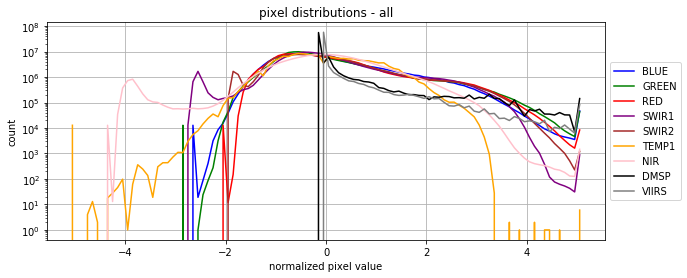

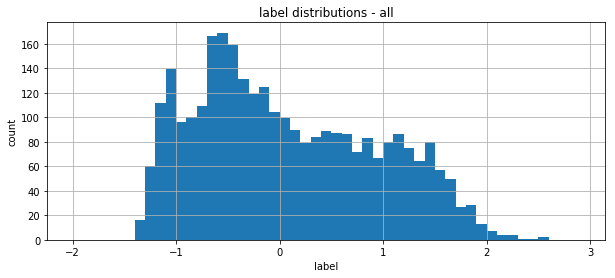

In [10]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(band_hists, BAND_ORDER_NLSPLIT, BAND_BIN_CENTERS,
    xlabel='normalized pixel value', ylabel='count', title='pixel distributions - all', yscale='log')
plot_label_hist(labels, LABEL_BIN_CENTERS, title='label distributions - all')

## Standardize histograms

In [11]:
image_hists_mean = np.mean(image_hists, axis=0, dtype=np.float64)
image_hists_std = np.std(image_hists, axis=0, dtype=np.float64)
standardized_image_hists = (image_hists - image_hists_mean) / (image_hists_std + 1e-6)
print(standardized_image_hists.shape)

(3020, 9, 102)


# Load data

In [12]:
LSMS_CSV_PATH = '../data/lsms_wealth_index.csv'
lsms_df = pd.read_csv(LSMS_CSV_PATH, float_precision='high')

# add tfrecords_index, nls_center, and nls_mean columns
def row_to_tfrecords_index(latlonyear):
    lat, lon, year = latlonyear
    lat, lon = np.float32(lat), np.float32(lon)
    return loc_to_tfrecords_index[(lat, lon, year)]

loc_to_tfrecords_index = {
    (lat, lon, year): i
    for i, ((lat, lon), year) in enumerate(zip(locs, years))
}

lsms_df['tfrecords_index'] = lsms_df[['lat', 'lon', 'year']].apply(row_to_tfrecords_index, axis=1, raw=True)
lsms_df['nls_center'] = nls_center[lsms_df['tfrecords_index']]
lsms_df['nls_mean'] = nls_mean[lsms_df['tfrecords_index']]

In [13]:
with pd.option_context('display.max_rows', 6):
    display(lsms_df)

,lat,lon,year,country,index_all,ea_id,index_rep,et_index,n,geolev1,...,phone,radio,tv,auto,floor_qual,toilet_qual,watsup_qual,tfrecords_index,nls_center,nls_mean
0,-0.292248,31.478722,2005,uganda,0.045405,1110003,0.042136,NaN,8.0,UGA.53,...,0.125,0.75,0.75,0.0,1.750,3.250000,3.500,2574,-0.161126,-0.161126
1,-0.292248,31.478722,2009,uganda,-0.333650,1110003,-0.326794,NaN,8.0,UGA.53,...,0.500,0.75,0.00,0.0,1.000,3.750000,3.625,2694,-0.161126,-0.161126
2,-0.292248,31.478722,2013,uganda,-0.386531,1110003,-0.373920,NaN,8.0,UGA.53,...,0.375,0.75,0.00,0.0,1.375,3.875000,3.000,2941,-0.083399,-0.081302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,9.917938,11.689417,2015,nigeria,0.119982,590,0.017382,NaN,1.0,NGA.16,...,0.000,1.00,0.00,0.0,2.000,3.000000,4.000,1626,-0.078012,-0.076090
3018,9.991906,37.692553,2011,ethiopia,-1.261734,3061102207,-1.259458,-0.730667,9.0,ETH.3,...,0.000,0.00,0.00,0.0,1.000,1.000000,3.000,120,-0.161126,-0.161126
3019,9.991906,37.692553,2015,ethiopia,-1.187214,3061102207,-1.186825,-0.621825,9.0,ETH.3,...,0.000,0.00,0.00,0.0,1.000,1.111111,3.000,449,-0.082880,-0.081012


In [14]:
# save nl values to CSV
# lsms_nl_df = lsms_df[['lat', 'lon', 'year', 'country', 'nls_center', 'nls_mean']]
# lsms_nl_df.to_csv('../data/lsms_nls.csv', index=False)

In [15]:
LSMS_COUNTRIES = ['ethiopia', 'malawi', 'nigeria', 'tanzania', 'uganda']

# convert lat/lon to float32
for col in ['lat', 'lon']:
    lsms_df[col] = lsms_df[col].astype(np.float32)

# create mapping: loc => country
loc_to_country = (lsms_df
    .groupby(['lat', 'lon'])
    .apply(lambda df: df['country'].iloc[0])
    .to_dict())

country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(lsms_df), dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_to_country[tuple(loc)]
    country_indices[country].append(i)

for i, country in enumerate(LSMS_COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

In [16]:
valid_mask = lsms_df['n'].notna()
dmsp_mask = valid_mask & (lsms_df['year'] < 2012)
viirs_mask = valid_mask & (lsms_df['year'] >= 2012)
uganda_mask = lsms_df['n'].notna() & (lsms_df['country'] == 'uganda') & (lsms_df['year'].isin([2005, 2009]))

labels_new = lsms_df.loc[valid_mask, 'index_rep'].values
country_labels_new = lsms_df.loc[valid_mask, 'country'].values
years_new = lsms_df.loc[valid_mask, 'year'].values

# Dumb Baseline Models

## Incountry: predict country mean

In [17]:
mean_preds = np.zeros_like(labels_new)
for country in LSMS_COUNTRIES:
    mask = (country_labels_new == country)
    mean_preds[mask] = np.mean(labels_new[mask])
r2, _, _, _ = evaluate(labels_new, mean_preds, do_print=True)

r^2: 0.564, R^2: 0.564, mse: 0.324, rank: 0.757


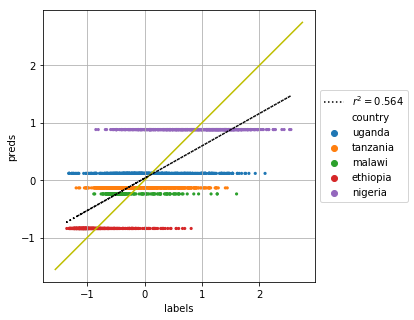

In [18]:
scatter_preds(labels_new, preds=mean_preds, by_name='country', by_col=country_labels_new)

## Linear NL

In [19]:
def linear_nl():
    linear_nl_df = pd.DataFrame(columns=['sensor', 'nl_type', 'weighted', 'r2'])
    linear_nl_df.set_index(['sensor', 'nl_type', 'weighted'], inplace=True)

    for sensor, mask in [('dmsp', dmsp_mask), ('viirs', viirs_mask)]:
        for nl_type in ['nls_center', 'nls_mean']:
            for weighted, w in [(False, None), (True, lsms_df.loc[mask, 'n'])]:
                linear_nl_df.loc[(sensor, nl_type, weighted)] = calc_score(
                    lsms_df.loc[mask, 'index_rep'], lsms_df.loc[mask, nl_type], metric='r2', weights=w)
    display(linear_nl_df.unstack('weighted'))

linear_nl()

print('Uganda nls_center, r^2 =',
      calc_score(lsms_df.loc[uganda_mask, 'nls_center'], lsms_df.loc[uganda_mask, 'index_rep'], metric='r2'))
print('Uganda nls_mean, r^2 =',
      calc_score(lsms_df.loc[uganda_mask, 'nls_mean'], lsms_df.loc[uganda_mask, 'index_rep'], metric='r2'))

r2          
weighted              False     True 
sensor nl_type                       
dmsp   nls_center  0.034556  0.028925
       nls_mean    0.083379  0.070432
viirs  nls_center  0.097060  0.112499
       nls_mean    0.067228  0.066957

Uganda nls_center, r^2 = 0.27474846566286404
Uganda nls_mean, r^2 = 0.29981093038506845


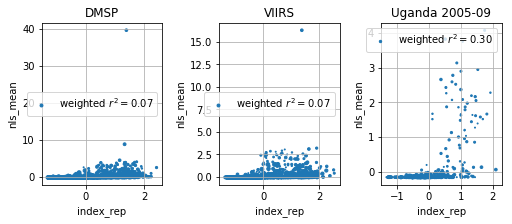

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
lsms_df.loc[dmsp_mask].plot.scatter(
    x='index_rep', y='nls_mean', s=lsms_df.loc[dmsp_mask, 'n'], ax=axs[0],
    label='weighted $r^2 = 0.07$')
lsms_df.loc[viirs_mask].plot.scatter(
    x='index_rep', y='nls_mean', s=lsms_df.loc[viirs_mask, 'n'], ax=axs[1],
    label='weighted $r^2 = 0.07$')
lsms_df.loc[uganda_mask].plot.scatter(
    x='index_rep', y='nls_mean', s=lsms_df.loc[uganda_mask, 'n'], ax=axs[2],
    label='weighted $r^2 = 0.30$')
axs[0].set_title('DMSP')
axs[1].set_title('VIIRS')
axs[2].set_title('Uganda 2005-09')
for ax in axs:
    ax.grid(True)
    ax.legend()

# OOC Predictions

In [14]:
def run_ooc(country, band_indices):
    nbands = len(band_indices)
    nbins = len(BAND_BIN_CENTERS)
    test_group = LSMS_COUNTRIES.index(country)
    num_examples = len(normalized_image_hists)
    test_preds, coefs, intercept = train_linear_logo(
        features=normalized_image_hists[:, band_indices, :].reshape(num_examples, -1),
        labels=labels,
        group_labels=country_labels,
        cv_groups=[i for i in range(len(LSMS_COUNTRIES)) if test_group != i],
        test_groups=[test_group],
        plot=True, group_names=LSMS_COUNTRIES, return_weights=True)
    print('best intercept:', intercept)
    per_band_coefs = coefs.reshape(nbands, nbins)
    plot_band_hists(per_band_coefs, np.asarray(BAND_ORDER_NLSPLIT)[band_indices], BAND_BIN_CENTERS,
        xlabel='normalized pixel value', ylabel='weight', title='Ridge Regression Weights per Band', yscale='linear')
    return evaluate(test_preds, labels[country_indices[country]], do_print=True)

## rgb

=== ethiopia ===


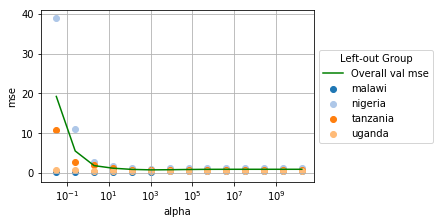

best val mse: 0.796, best alpha: 1024.0, test mse: 1.149
best intercept: 0.2766538238524851


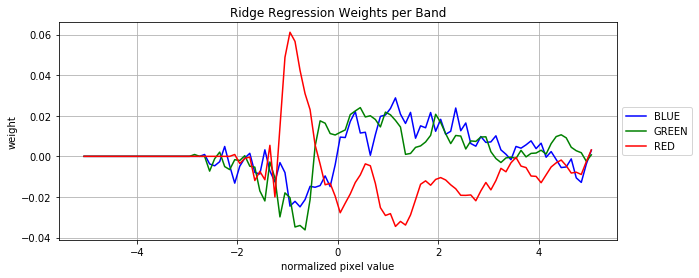

r^2: 0.003, R^2: -12.699, mse: 1.149, rank: -0.099
=== malawi ===


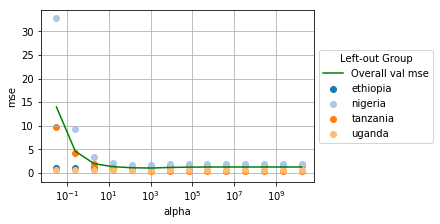

best val mse: 1.002, best alpha: 1024.0, test mse: 0.248
best intercept: 0.05904070623287575


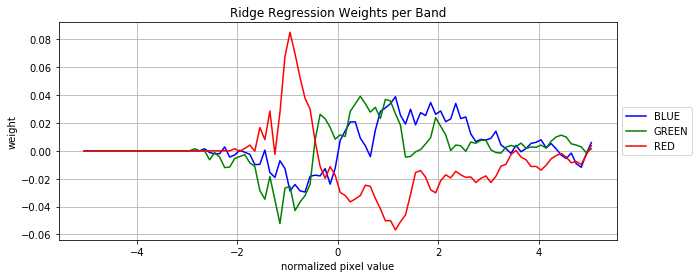

r^2: 0.037, R^2: -3.736, mse: 0.248, rank: 0.170
=== nigeria ===


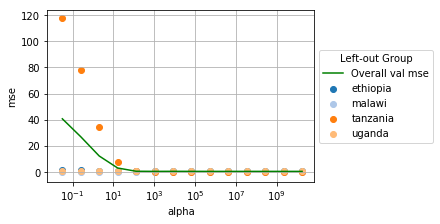

best val mse: 0.591, best alpha: 17179869184.0, test mse: 1.870
best intercept: -0.3135659352767565


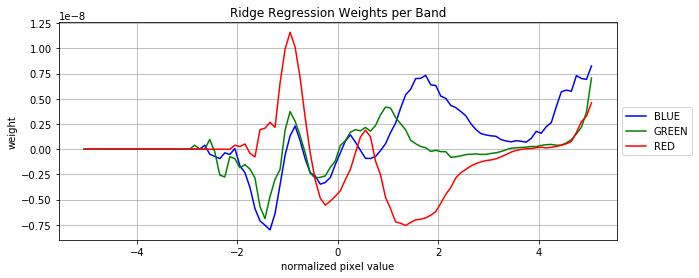

r^2: 0.000, R^2: -141996216512211.438, mse: 1.870, rank: 0.094
=== tanzania ===


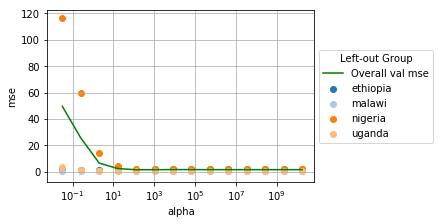

best val mse: 1.492, best alpha: 128.0, test mse: 0.617
best intercept: 0.14841169455581213


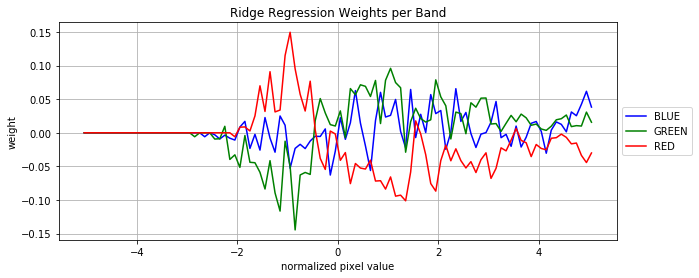

r^2: 0.218, R^2: -0.052, mse: 0.617, rank: 0.492
=== uganda ===


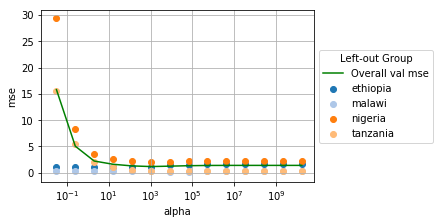

best val mse: 1.190, best alpha: 1024.0, test mse: 0.522
best intercept: 0.060024751315156395


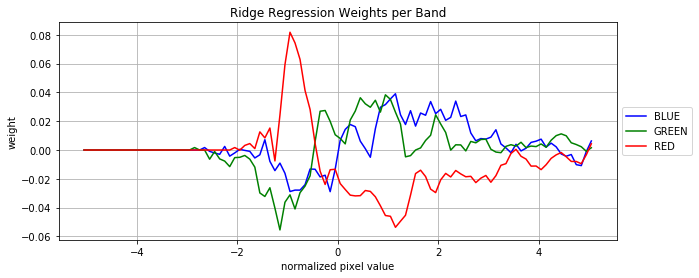

r^2: 0.009, R^2: -8.317, mse: 0.522, rank: 0.055


In [15]:
rgb_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
rgb_df.set_index('country', inplace=True)

for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    rgb_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['rgb'])

In [16]:
colordisplay(rgb_df)

,r2,R2,mse,rank
country,,,,
ethiopia,0.00275165,-12.6989,1.14938,-0.0985496
malawi,0.037049,-3.73572,0.247897,0.169638
nigeria,0.000291603,-1.41996e+14,1.86967,0.0938802
tanzania,0.217606,-0.0522983,0.616936,0.492312
uganda,0.00912378,-8.31685,0.521783,0.0551003


## ms

=== ethiopia ===


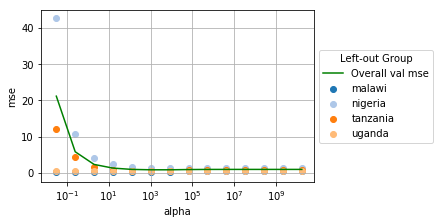

best val mse: 0.834, best alpha: 8192.0, test mse: 1.435
best intercept: 0.307940844271197


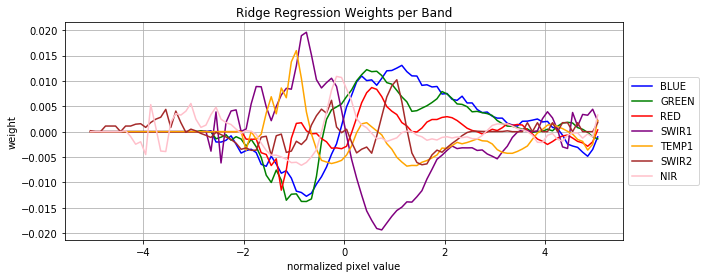

r^2: 0.000, R^2: -16.165, mse: 1.435, rank: -0.095
=== malawi ===


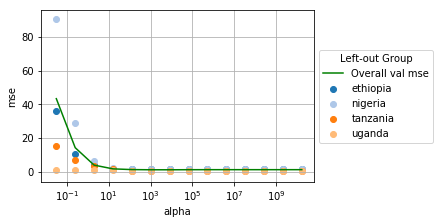

best val mse: 1.156, best alpha: 8192.0, test mse: 0.183
best intercept: 0.06870725539382323


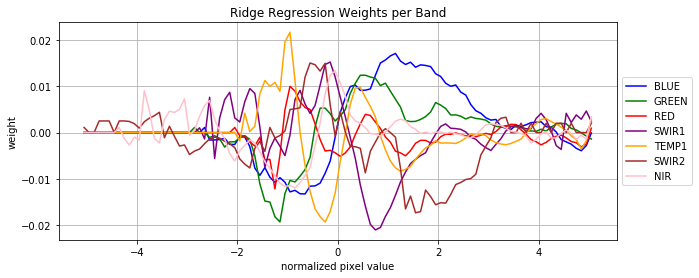

r^2: 0.121, R^2: -4.622, mse: 0.183, rank: 0.357
=== nigeria ===


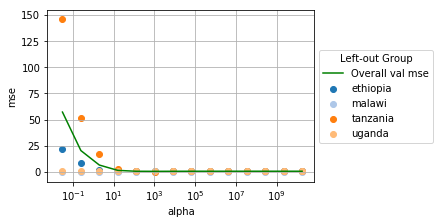

best val mse: 0.499, best alpha: 1024.0, test mse: 1.803
best intercept: -0.30521542536561996


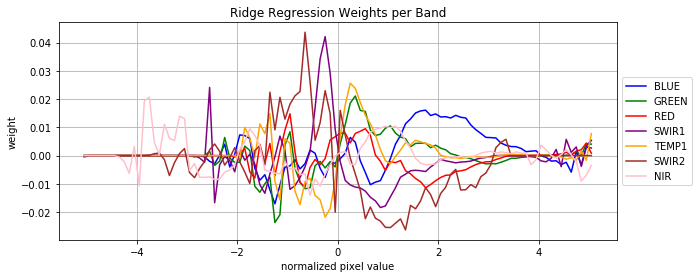

r^2: 0.092, R^2: -11.446, mse: 1.803, rank: 0.312
=== tanzania ===


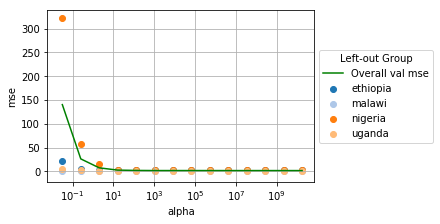

best val mse: 1.573, best alpha: 17179869184.0, test mse: 0.401
best intercept: 0.13493993774708507


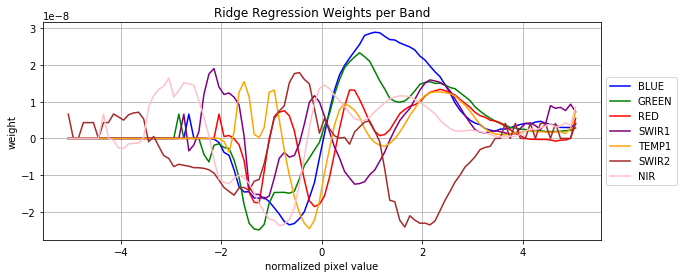

r^2: 0.082, R^2: -333709375606.974, mse: 0.401, rank: 0.342
=== uganda ===


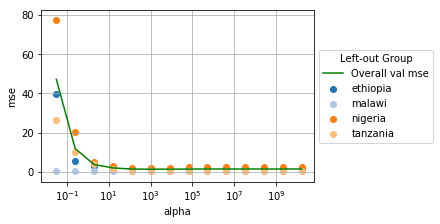

best val mse: 1.300, best alpha: 1024.0, test mse: 0.537
best intercept: 0.03960880183052784


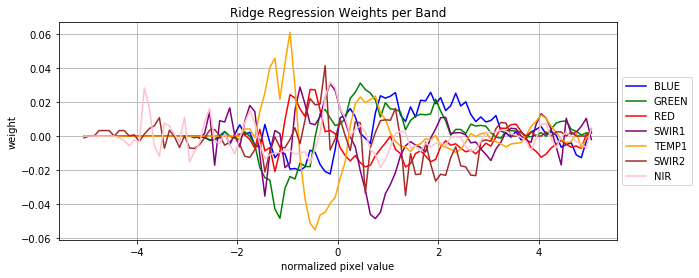

r^2: 0.046, R^2: -4.044, mse: 0.537, rank: 0.149


In [17]:
ms_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
ms_df.set_index('country', inplace=True)

for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    ms_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['ms'])

In [18]:
colordisplay(ms_df)

,r2,R2,mse,rank
country,,,,
ethiopia,0.000476464,-16.1652,1.43454,-0.0946592
malawi,0.121195,-4.62202,0.1835,0.356824
nigeria,0.0924692,-11.4456,1.80254,0.312422
tanzania,0.0817442,-3.33709e+11,0.400714,0.342041
uganda,0.0460507,-4.0438,0.536555,0.149028


## nl

=== ethiopia ===


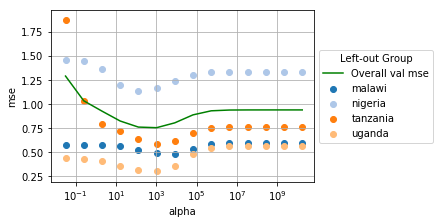

best val mse: 0.755, best alpha: 1024.0, test mse: 0.939
best intercept: 0.26349741566925267


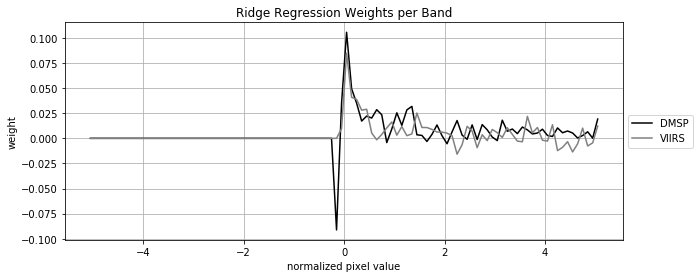

r^2: 0.044, R^2: -45.934, mse: 0.939, rank: 0.242
=== malawi ===


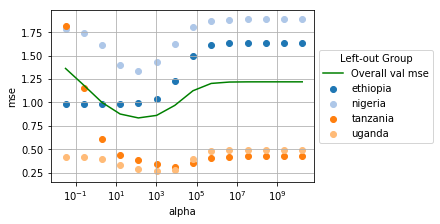

best val mse: 0.834, best alpha: 128.0, test mse: 0.335
best intercept: 0.10007132704437026


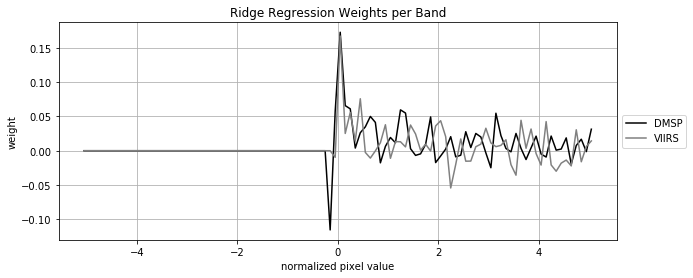

r^2: 0.599, R^2: 0.054, mse: 0.335, rank: 0.647
=== nigeria ===


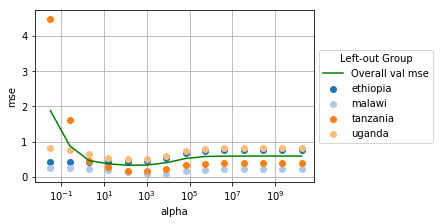

best val mse: 0.332, best alpha: 128.0, test mse: 1.381
best intercept: -0.25445136713784583


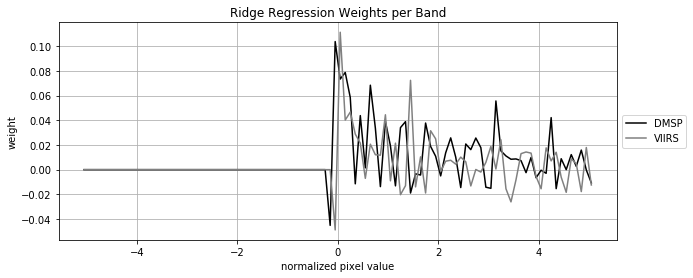

r^2: 0.280, R^2: -3.690, mse: 1.381, rank: 0.481
=== tanzania ===


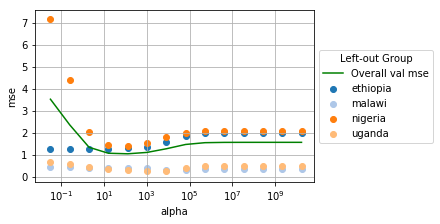

best val mse: 1.053, best alpha: 128.0, test mse: 0.355
best intercept: 0.15474021108706526


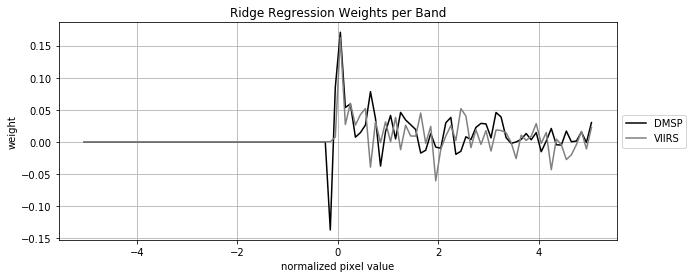

r^2: 0.489, R^2: 0.124, mse: 0.355, rank: 0.595
=== uganda ===


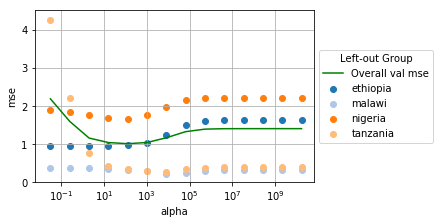

best val mse: 1.017, best alpha: 128.0, test mse: 0.293
best intercept: 0.05819219461884225


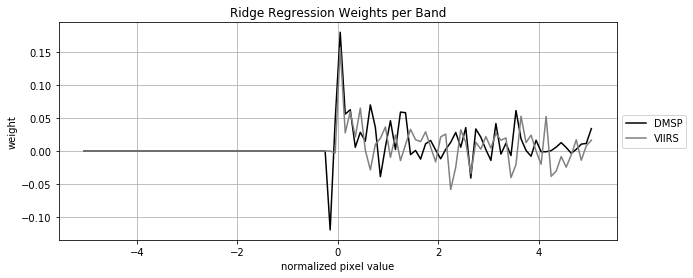

r^2: 0.454, R^2: 0.211, mse: 0.293, rank: 0.598


In [19]:
nl_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
nl_df.set_index('country', inplace=True)

for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    nl_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['nl'])

In [20]:
colordisplay(nl_df)

,r2,R2,mse,rank
country,,,,
ethiopia,0.0441678,-45.9336,0.939187,0.241722
malawi,0.599337,0.053813,0.335454,0.647462
nigeria,0.279512,-3.68988,1.38069,0.481245
tanzania,0.488784,0.123997,0.355392,0.595131
uganda,0.454391,0.210772,0.293278,0.597761


## msnl

=== ethiopia ===


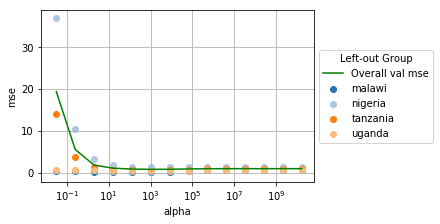

best val mse: 0.777, best alpha: 1024.0, test mse: 1.087
best intercept: 0.2702712690306847


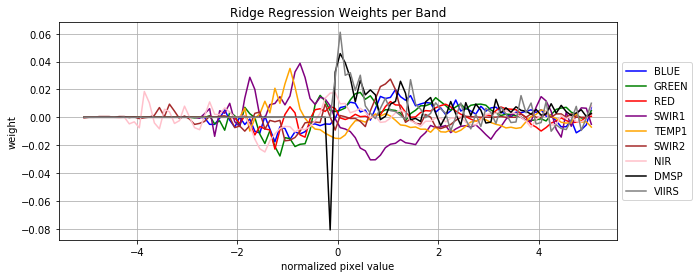

r^2: 0.007, R^2: -8.950, mse: 1.087, rank: 0.033
=== malawi ===


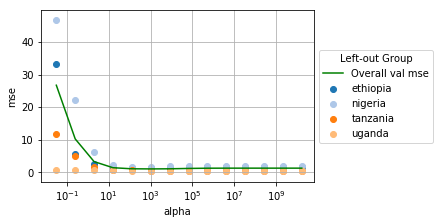

best val mse: 0.984, best alpha: 1024.0, test mse: 0.123
best intercept: 0.0702068623841288


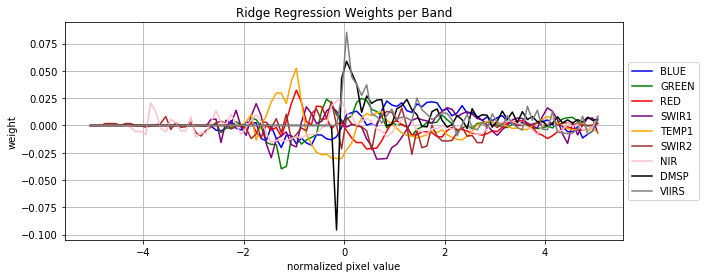

r^2: 0.522, R^2: 0.472, mse: 0.123, rank: 0.647
=== nigeria ===


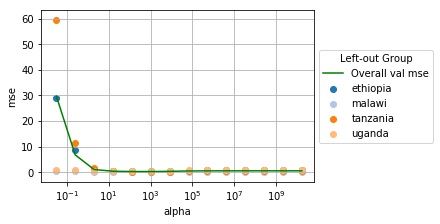

best val mse: 0.312, best alpha: 1024.0, test mse: 1.627
best intercept: -0.29656884557521934


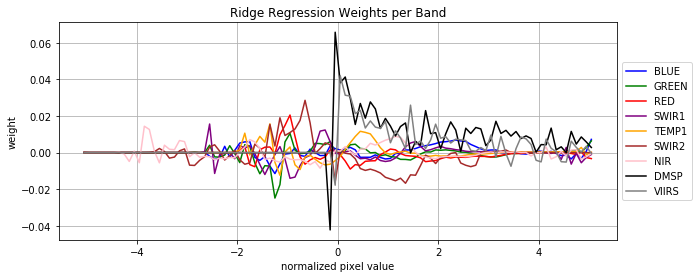

r^2: 0.315, R^2: -5.988, mse: 1.627, rank: 0.588
=== tanzania ===


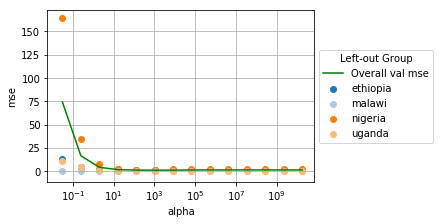

best val mse: 1.305, best alpha: 1024.0, test mse: 0.386
best intercept: 0.14007206626805563


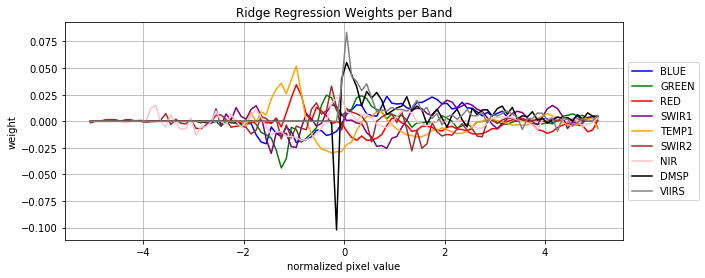

r^2: 0.399, R^2: 0.159, mse: 0.386, rank: 0.566
=== uganda ===


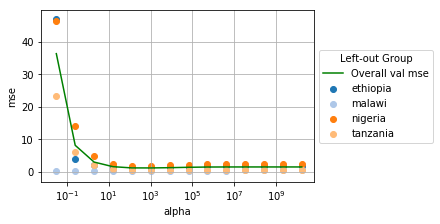

best val mse: 1.108, best alpha: 1024.0, test mse: 0.375
best intercept: 0.04333089862176054


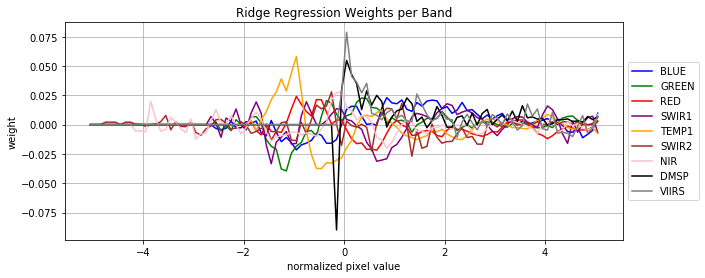

r^2: 0.317, R^2: -0.502, mse: 0.375, rank: 0.369


In [21]:
msnl_df = pd.DataFrame(columns=['country', 'r2', 'R2', 'mse', 'rank'], dtype=np.float64)
msnl_df.set_index('country', inplace=True)

for country in LSMS_COUNTRIES:
    print(f'=== {country} ===')
    msnl_df.loc[country, :] = run_ooc(country, band_indices=BANDS_DICT['msnl'])

In [22]:
colordisplay(msnl_df)

,r2,R2,mse,rank
country,,,,
ethiopia,0.00669636,-8.95016,1.08659,0.0326322
malawi,0.52154,0.472225,0.12288,0.647481
nigeria,0.315273,-5.98818,1.62681,0.587517
tanzania,0.398929,0.158528,0.386328,0.566405
uganda,0.316965,-0.501745,0.374977,0.368807


# Incountry Predictions

In [14]:
# load incountry folds
file_path = '../data/lsms_incountry_folds.pkl'
with open(file_path, 'rb') as f:
    incountry_folds = pickle.load(f)

In [15]:
num_examples = len(image_hists)
incountry_group_labels = np.zeros(num_examples, dtype=np.int32)
for i, f in enumerate(FOLDS):
    test_indices = incountry_folds[f]['test']
    incountry_group_labels[test_indices] = i

## Predict country mean

In [16]:
mean_preds = np.zeros(num_examples)
for i, country in enumerate(LSMS_COUNTRIES):
    indices = np.where(country_labels == i)[0]
    mean_preds[indices] = np.mean(labels[indices])
r2, R2, mse, rank = evaluate(labels, mean_preds, do_print=True)

r^2: 0.551, R^2: 0.551, mse: 0.337, rank: 0.748


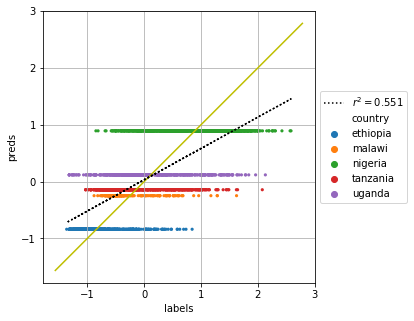

In [17]:
scatter_preds(
    labels=labels,
    preds=mean_preds,
    by_name='country',
    by_col=np.asarray(LSMS_COUNTRIES)[country_labels])

## Histogram model

In [18]:
def run_incountry(features, labels, incountry_group_labels):
    num_examples = len(features)
    test_preds = np.zeros(num_examples, dtype=np.float32)

    do_plot = True
    for i, fold in enumerate(FOLDS):
        print('Fold:', fold)
        test_indices = incountry_folds[fold]['test']
        test_preds[test_indices] = train_linear_logo(
            features=features,
            labels=labels,
            group_labels=incountry_group_labels,
            cv_groups=[x for x in range(5) if x != i],
            test_groups=[i],
            plot=do_plot,
            group_names=FOLDS)
        do_plot = False
    return test_preds

Fold: A


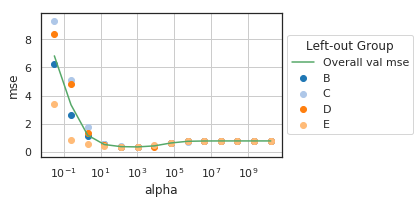

best val mse: 0.348, best alpha: 1024.0, test mse: 0.373
Fold: B
best val mse: 0.359, best alpha: 1024.0, test mse: 0.348
Fold: C
best val mse: 0.355, best alpha: 1024.0, test mse: 0.353
Fold: D
best val mse: 0.364, best alpha: 1024.0, test mse: 0.319
Fold: E
best val mse: 0.356, best alpha: 1024.0, test mse: 0.340
r^2: 0.538, R^2: 0.103, mse: 0.347, rank: 0.733


In [26]:
test_preds = run_incountry(
    normalized_image_hists.reshape(num_examples, -1), labels, incountry_group_labels)

In [29]:
test_preds_df = pd.DataFrame(data={
    'preds': test_preds,
    'labels': labels,
    'country': np.asarray(LSMS_COUNTRIES)[country_labels],
    'year': years
})
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

,preds,labels,country,year
0,-0.744204,-1.232088,ethiopia,2011
1,-0.163558,-0.869557,ethiopia,2011
...,...,...,...,...
3018,1.015059,1.379230,uganda,2013
3019,1.070682,1.180093,uganda,2013


In [36]:
def evaluate_df(df):
    '''
    Args
    - df: pd.DataFrame, contains columns ['preds', 'labels']

    Returns: pd.Series, index ['r2', 'R2', 'mse', 'rank']
    '''
    r2, R2, mse, rank = evaluate(df['preds'], df['labels'])
    return pd.Series({'r2': r2, 'R2': R2, 'mse': mse, 'rank': rank})

results_bycountry_df = test_preds_df.groupby('country').apply(evaluate_df)
results_bycountry_df.loc['all', :] = evaluate_df(test_preds_df)
colordisplay(results_bycountry_df)

,r2,R2,mse,rank
country,,,,
ethiopia,0.022593,-2.40588,0.368855,0.158077
malawi,0.535267,0.477263,0.115779,0.639102
nigeria,0.294455,-0.5601,0.46721,0.561145
tanzania,0.446941,0.292438,0.263773,0.585378
uganda,0.402968,-0.487912,0.295996,0.486439
overall,0.537902,0.10346,0.346778,0.732542


In [37]:
results_bycy_df = test_preds_df.groupby(['country', 'year']).apply(evaluate_df)
colordisplay(results_bycy_df)